## An example for distribution of extreme values 

In [1]:
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from photutils import DAOStarFinder

In [2]:
%matplotlib notebook

## Distribution of random peaks taken from a gaussian distribution:

<IPython.core.display.Javascript object>


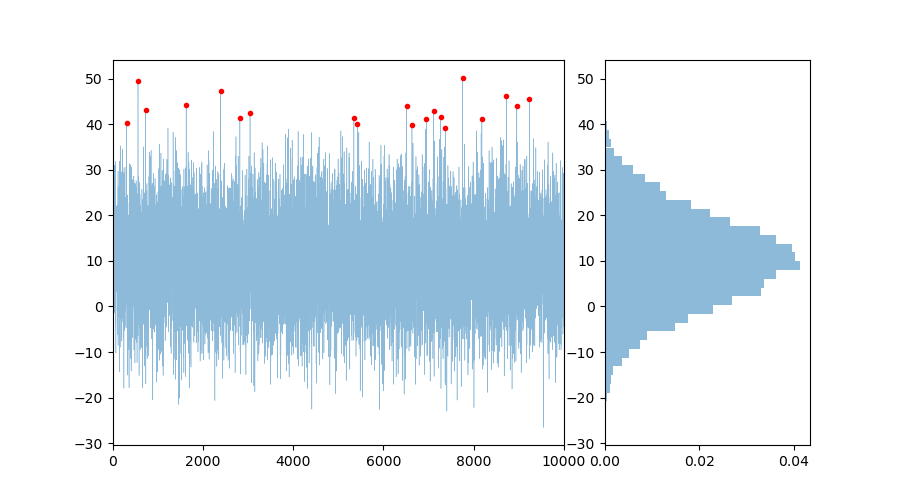

In [3]:
np.random.seed(1)

source = st.norm(10,10)
sampsize = 10000
npeaks = 20
samp = source.rvs(sampsize)

# We select a total of <npeaks> number of peaks:
extremes = samp[samp.argsort()[-npeaks:]]

fig = plt.figure(figsize=(9,5))
grid = fig.add_gridspec(1,3)
ax0 = fig.add_subplot(grid[:2])
ax0.plot(samp,lw=0.4,alpha=0.5)
ax0.plot(samp.argsort()[-npeaks:],extremes,'.r')
ax0.set(xlim=[0,sampsize])
ax1 = fig.add_subplot(grid[2])
ax1.hist(samp,orientation='horizontal',bins=40,density=True,alpha=0.5);

20 peaks is a small sample size. Thus we do it iteratively on multiple similar data sets 
and extract 20 peaks each time and combine all of them into a distribution of extremes and fit them.

For the model distribution, we use `scipy.stats.genextreme` (see [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genextreme.html#scipy.stats.genextreme)) which is a generalized Gubmle distribution.

<IPython.core.display.Javascript object>


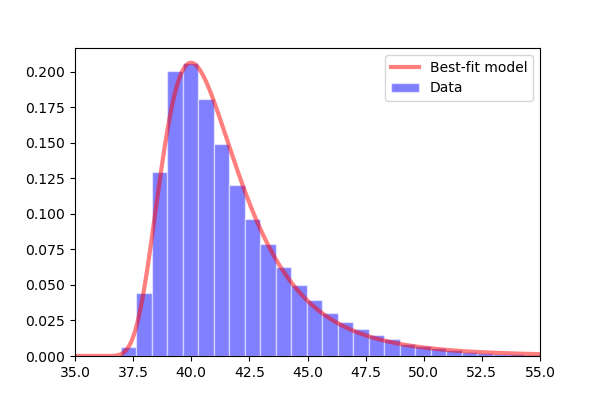

In [4]:
for i in range(sampsize):
    samp = source.rvs(sampsize)
    extremes = np.concatenate((extremes,samp[samp.argsort()[-npeaks:]]))

xtest = np.linspace(30,65,1000)
pars = st.genextreme.fit(extremes)

fig = plt.figure(figsize=(6,4))
ax0 = fig.add_subplot(1,1,1)
ax0.hist(extremes,bins=50,density=True,edgecolor='w',color='b',alpha=0.5,label='Data')
ax0.plot(xtest,st.genextreme(pars[0], pars[1], pars[2]).pdf(xtest),lw=3,color='r',alpha=0.5,label='Best-fit model')
ax0.legend()
ax0.set(xlim=[35,55]);

So the example above is a rather ideal scenario, now let's make things a tiny bit more complicated:

## Distribution of fluxes in sources detected in a 2D image

We create an artificial image (an ideal one, meaning noise is gaussian in amplitude and uniform across the image, and all sources are symmetric point sources) using gaussian and bernouli processes. Then, we apply a gaussian spatial filter to mimick a point-spread function or beam effect. Finally, we run a basic source detection (in this case `DAOPHOT`, a commonly used package in optical astronomy) on it with a 4-sigma detection threshold and check the flux of those detections.

<IPython.core.display.Javascript object>


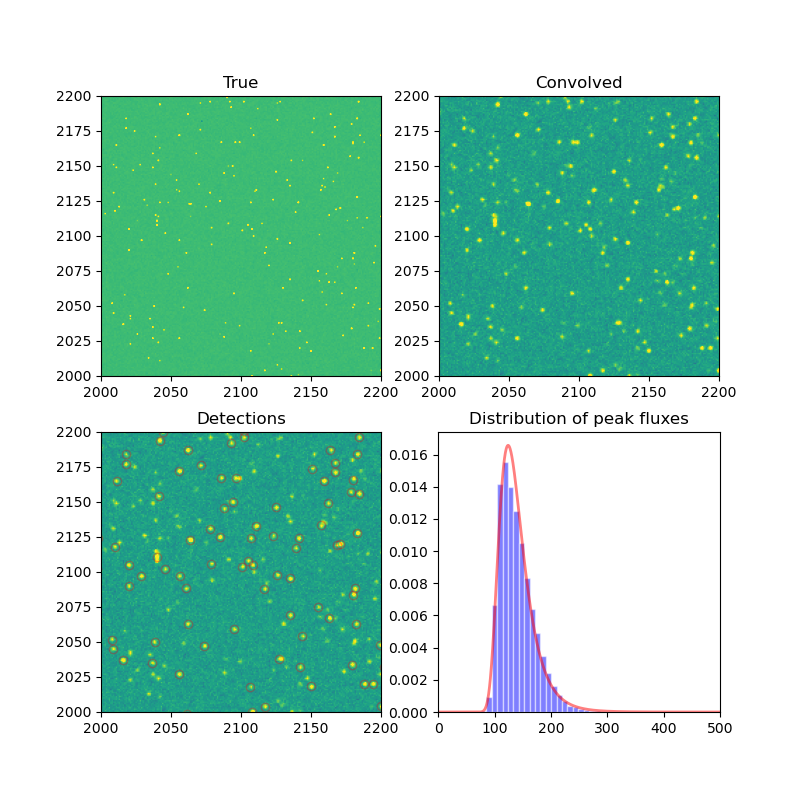

In [5]:
np.random.seed(1231)

background = st.norm(200,10)
source_occurrence = st.bernoulli(0.005)
source = st.norm(600,300)

kernel = Gaussian2DKernel(x_stddev=1)

sampsize = 5000
samp_true = background.rvs([sampsize,sampsize])+source_occurrence.rvs([sampsize,sampsize]) * source.rvs([sampsize,sampsize])
samp_conv = background.rvs([sampsize,sampsize])+convolve(samp_true,kernel)

daofind = DAOStarFinder(fwhm=1.0, threshold=4*samp_conv.std())  
sources = daofind(samp_conv - np.median(samp_conv))
xtest = np.linspace(0,500,1000)
pars = st.genextreme.fit(sources['peak'].data)

fig = plt.figure(figsize=(8,8))
grid = fig.add_gridspec(2,2)
ax0 = fig.add_subplot(grid[0])
ax0.imshow(samp_true,vmax=500)
ax0.set(title='True',xlim=[2000,2200],ylim=[2000,2200])
ax1 = fig.add_subplot(grid[1])
ax1.imshow(samp_conv,vmax=500)
ax1.set(title='Convolved',xlim=[2000,2200],ylim=[2000,2200])
ax2 = fig.add_subplot(grid[2])
ax2.imshow(samp_conv,vmax=500)
ax2.plot(sources['xcentroid'],sources['ycentroid'],'or',markerfacecolor='none',alpha=0.3)
ax2.set(title='Detections',xlim=[2000,2200],ylim=[2000,2200])
ax3 = fig.add_subplot(grid[3])
ax3.hist(sources['peak'].data,bins=30,density=True,edgecolor='w',color='b',alpha=0.5)
ax3.plot(xtest,st.genextreme(pars[0], pars[1], pars[2]).pdf(xtest),lw=2,color='r',alpha=0.5)
ax3.set(xlim=[0,500]);
ax3.set(title='Distribution of peak fluxes');